In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext rpy2.ipython

In [31]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from kaggle.house_prices import api
from kaggle.house_prices import helpers
from kaggle.house_prices import model_selection
from kaggle.house_prices import plot
from kaggle.house_prices import utils
from kaggle.house_prices.notebook import Plot, ggplot2, grid_plot

################################
# load data, missing, outliers #
################################
combined_dataset_step1 = api.stage1_transformation(helpers.load_data())
combined_dataset_step1.shape

################################
# transform numeric predictors #
################################
combined_dataset_step2, trans_config = api.stage2_transformation(
    combined_dataset_step1,
    threshold=20
)

trans_config

utils.frames_diff(
    combined_dataset_step1.drop(columns=['price_log']),
    combined_dataset_step2.drop(columns=['price_log'])
).head()

####################################                
# transform categorical predictors #
####################################
combined_dataset_step3 = api.stage3_transformation(combined_dataset_step2)

utils.frames_diff(
    combined_dataset_step2.drop(columns=['price_log']),
    combined_dataset_step3.drop(columns=['price_log'])
).head()

(2917, 81)

,var,progress_score,tran,tran_fn,r2_x,r2_tran
0,GrLivArea,91.157942,log,<function stage2_transformation.<locals>.<lamb...,0.525931,0.543804
3,LotArea,78.864026,inv4,<function stage2_transformation.<locals>.<lamb...,0.067883,0.159187
4,TotRmsAbvGrd,30.685015,log,<function stage2_transformation.<locals>.<lamb...,0.289123,0.293868


,GrLivArea.1,GrLivArea.2,LotArea.1,LotArea.2,TotRmsAbvGrd.1,TotRmsAbvGrd.2
0,1710,7.444833,8450,9.587694,8,2.197225
1,1262,7.141245,9600,9.898464,6,1.945910
2,1786,7.488294,11250,10.298836,6,1.945910
3,1717,7.448916,9550,9.885550,7,2.079442
4,2198,7.695758,14260,10.927728,9,2.302585


,Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,...,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
0,_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
1,_none_,2.531822,1Fam,2.564039,TA,2.540871,Gd,3.295455,ALQ,2.231818,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
2,_none_,2.531822,1Fam,2.564039,TA,2.540871,Mn,2.675439,GLQ,3.262019,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
3,_none_,2.531822,1Fam,2.564039,Gd,3.046154,No,2.320042,ALQ,2.231818,...,Gable,2.418054,Abnorml,1.920792,WD,2.421468,Pave,2.499311,AllPub,2.496911
4,_none_,2.531822,1Fam,2.564039,TA,2.540871,Av,2.900452,GLQ,3.262019,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911


In [3]:
train_data = (
    combined_dataset_step3
    .query("dataSource == 'train'")
    .drop(columns=['dataSource'])
)

mod = smf.ols(formula='price_log ~ GrLivArea + OverallQual', data=train_data).fit()
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.764    
Dependent Variable: price_log        AIC:                -637.7728
Date:               2018-03-20 10:49 BIC:                -621.9183
No. Observations:   1458             Log-Likelihood:     321.89   
Df Model:           2                F-statistic:        2358.    
Df Residuals:       1455             Prob (F-statistic): 0.00     
R-squared:          0.764            Scale:              0.037728 
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     7.6589     0.1260   60.7671   0.0000   7.4117   7.9061
GrLivArea     0.4566     0.0194   23.4978   0.0000   0.4185   0.4947
OverallQual   0.1719     0.0047   36.8759   0.0000   0.1627   0.1810
------------------------------------------------------------------
Omnibus:             190.057       Durbin-Watson:          1.965  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       403.151
Skew:                -0.774        Prob(JB):               0.000  
Kurtosis:            5.060         Condition No.:          240    
==================================================================

"""

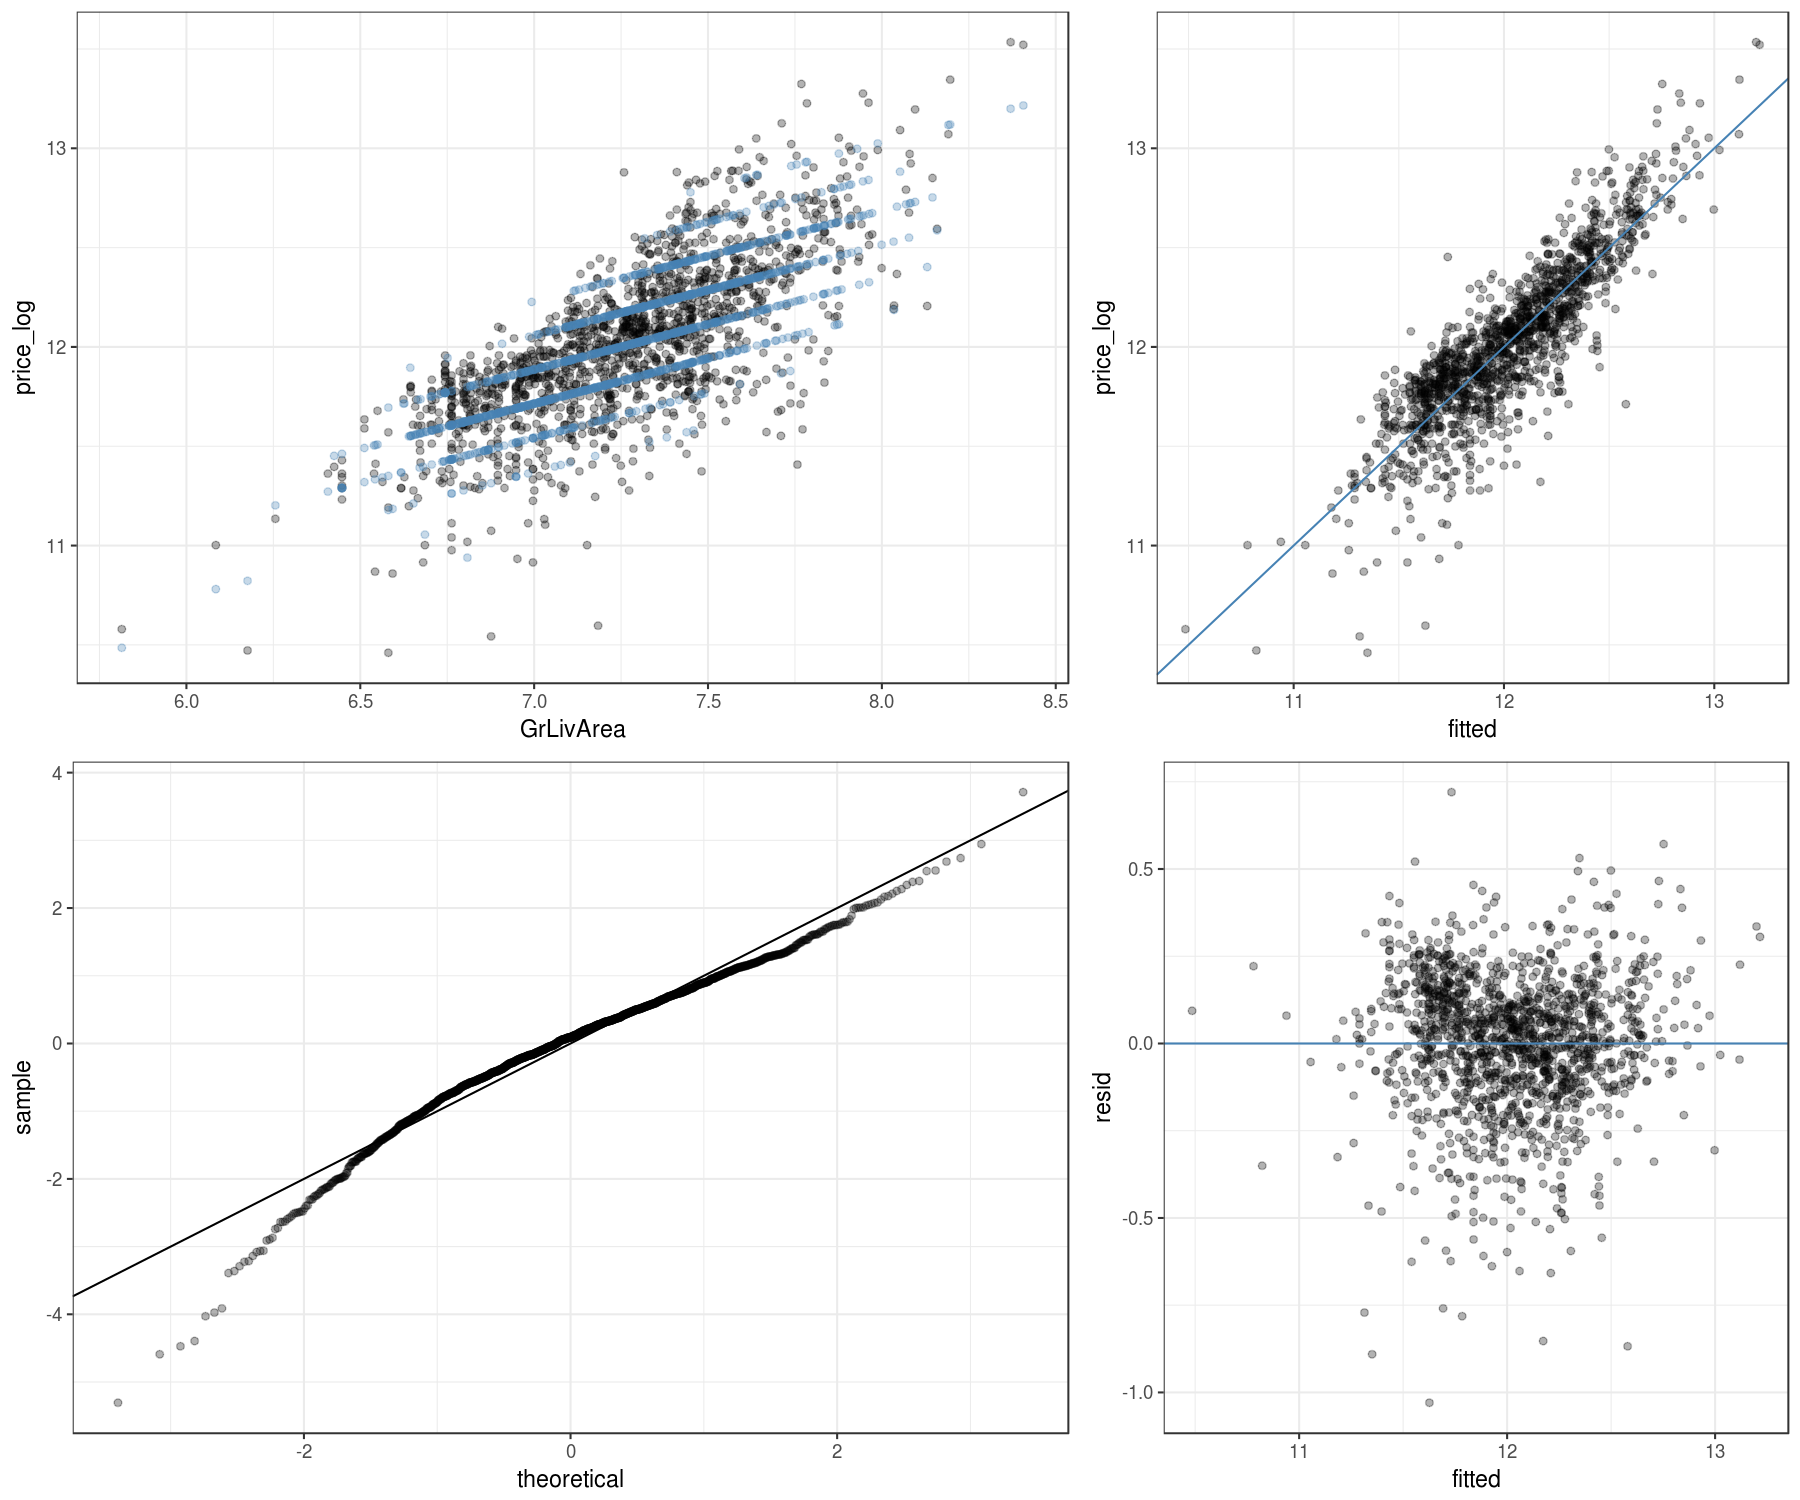

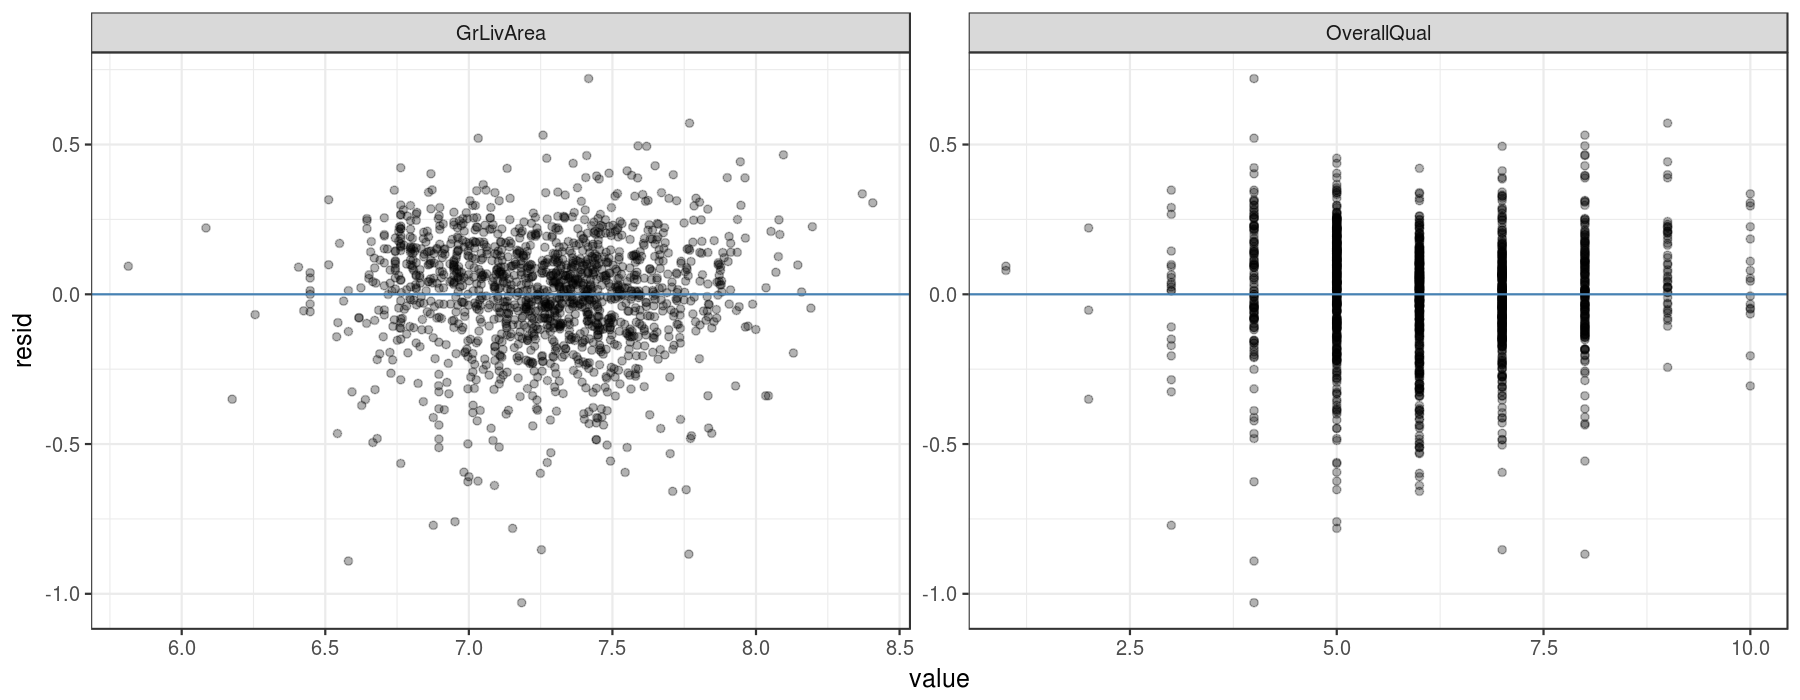

In [35]:
grid_plot(
    plots=plot.lm_fit_diagnostic(
        model=mod, 
        principal_predictor='GrLivArea', 
        target_var='price_log'
    ), 
    widths=[60, 40], 
    layout_matrix=[[1, 2], [3, 4]],
    display_params=dict(width=1800, height=1500, res=140)
)

with Plot(width=1800, height=700, res=150) as p:
    p(plot.lm_resid_vs_predictors(mod, 2, 1)) 